In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
!mkdir -p ~/.kaggle                                          
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
!cp kaggle.json ~/.kaggle/kaggle.json > log              
!chmod 600 ~/.kaggle/kaggle.json                            
!kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
!kaggle competitions download -c novozymes-enzyme-stability-prediction         
!unzip -o *.zip >> log                           
# !kaggle competitions leaderboard --show                

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: novozymes-enzyme-stability-prediction
 85% 6.00M/7.06M [00:00<00:00, 62.0MB/s]
100% 7.06M/7.06M [00:00<00:00, 71.0MB/s]


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv', low_memory=False); df

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


In [ ]:
df_test = pd.read_csv('test.csv', low_memory=False)
df_test.shape

(2413, 4)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction import text
from sklearn.random_projection import GaussianRandomProjection
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

SEED = 0

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df['protein_sequence'], df['tm'], test_size=1000, random_state=SEED, shuffle=True)

In [ ]:
tfidf = text.TfidfVectorizer(analyzer='char', ngram_range=(1,3))
trans_seq = tfidf.fit(train_X)
trigram = trans_seq.transform(train_X)
trigram_test = trans_seq.transform(test_X)

In [ ]:
project = GaussianRandomProjection(random_state=0, eps=0.2)
projector = project.fit(trigram) 
trigram_reduce = projector.transform(trigram)
trigram_reduce_test = projector.transform(trigram_test)

In [ ]:
trigram_reduce.shape

(30390, 2381)

In [ ]:
tf.random.set_seed(SEED)

callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0.0001,
                patience=10,
                verbose=0,
                mode="auto",
                baseline=None,
                restore_best_weights=True)
            ]

Init = tf.keras.initializers.Orthogonal(seed=SEED)

scaler = StandardScaler().fit(trigram_reduce)
trigram_reduce_in = scaler.transform(trigram_reduce)
trigram_reduce_test_in = scaler.transform(trigram_reduce_test)

model = tf.keras.models.Sequential([
    Flatten(input_shape=[trigram_reduce_in.shape[1]], name='input'),
    Dense(512, activation="relu", kernel_initializer=Init, name='hidden1'),#, use_bias=False),
    BatchNormalization(momentum=0.9),
    Dropout(0.5),
    Dense(512, activation="relu", kernel_initializer=Init, name='hidden2'),#, use_bias=False),
    BatchNormalization(momentum=0.9),
    Dropout(0.5),
    Dense(512, activation="relu", kernel_initializer=Init, name='hidden3'),#, use_bias=False),
    BatchNormalization(momentum=0.9),
    Dropout(0.5),
    Dense(512, activation="relu", kernel_initializer=Init, name='hidden4'),#, use_bias=False),
    Dense(1, activation='linear', kernel_initializer=Init, name='output')])
model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999))
hist = model.fit(trigram_reduce_in, train_y, epochs=70, validation_split=0.3, batch_size=4096, shuffle=True, callbacks=callbacks)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 2381)              0         
                                                                 
 hidden1 (Dense)             (None, 512)               1219584   
                                                                 
 batch_normalization_94 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 hidden2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_95 (Bat  (None, 512)              2048      
 chNormalization)                                    

In [ ]:
preds = model.predict(trigram_reduce_test_in)
spearman = stats.spearmanr(test_y, preds)
print(spearman)

32/32 [==============================] - 0s 2ms/step
SpearmanrResult(correlation=0.5747182645504592, pvalue=5.699718094192912e-89)


In [ ]:
test_final = trans_seq.transform(df_test['protein_sequence'])
test_final = projector.transform(test_final)
# test_final = scaler.transform(test_final)

(array([0.00072925, 0.00817528, 0.04037743, 0.17686237, 0.36163135,
        0.36071019, 0.1736767 , 0.03550297, 0.00782984, 0.00092116]),
 array([-4.2771735 , -3.41984684, -2.56252019, -1.70519353, -0.84786687,
         0.00945978,  0.86678644,  1.7241131 ,  2.58143975,  3.43876641,
         4.29609307]),
 <a list of 10 Patch objects>)

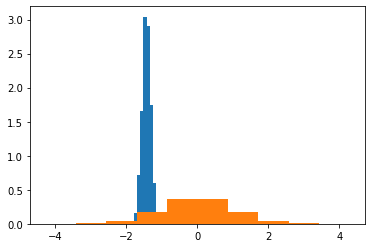

In [ ]:
from sklearn.preprocessing import PowerTransformer
power_trans = PowerTransformer().fit(trigram_reduce)

(array([2.27665939e-04, 3.64265502e-03, 3.61988843e-02, 1.55078449e-01,
        3.38880750e-01, 3.74168971e-01, 1.91011723e-01, 4.56849651e-02,
        7.32325437e-03, 9.10663756e-04]),
 array([-4.42711595, -3.55990952, -2.69270309, -1.82549666, -0.95829023,
        -0.0910838 ,  0.77612263,  1.64332906,  2.51053549,  3.37774192,
         4.24494835]),
 <a list of 10 Patch objects>)

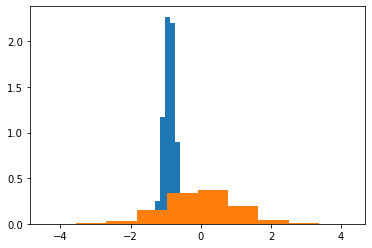

In [ ]:
plt.hist(power_trans.transform(test_final)[:, 300], density=True)
plt.hist(power_trans.transform(trigram_reduce)[:, 300], density=True)

(array([8.13788688e-03, 1.24780932e-01, 7.62248738e-01, 5.55003885e+00,
        1.62866243e+01, 2.62636736e+01, 2.44516375e+01, 7.71742939e+00,
        1.16914308e+00, 1.03079901e-01]),
 array([-0.05116757, -0.03903707, -0.02690656, -0.01477606, -0.00264555,
         0.00948495,  0.02161546,  0.03374597,  0.04587647,  0.05800698,
         0.07013748]),
 <a list of 10 Patch objects>)

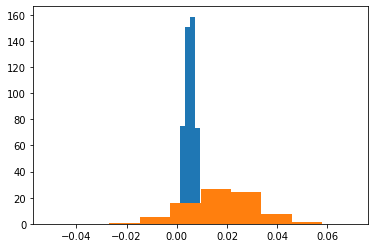

In [ ]:
plt.hist(test_final[:, 300], density=True)
plt.hist(trigram_reduce[:, 300], density=True)

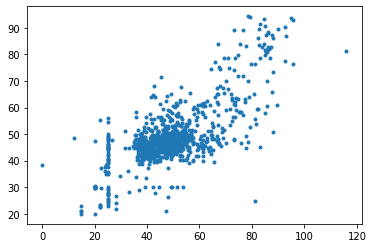

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(test_y, preds, '.')

In [ ]:
# model = GradientBoostingRegressor().fit(trigram_reduce[:20000], df['tm'][:20000])

In [ ]:
# characters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# char_to_num = {}
# for x in range(len(characters)):
#     char_to_num[characters[x]] = x

# def frequency_by_letter(protein_sequence):
#   frequencies = np.zeros((26))
#   for letter in protein_sequence:
#     char_num = char_to_num[letter]
#     frequencies[char_num] = frequencies[char_num] + 1
#   return frequencies

# letter_frequencies = df.protein_sequence.apply(frequency_by_letter)

In [ ]:
# df.insert(3, 'letter_frequencies', letter_frequencies, True)
# df

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split

# model = RandomForestRegressor(max_depth=500, random_state=0)

# X = np.stack(df.letter_frequencies.values, axis=0)
# y = np.asarray(df.tm.values)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# print(X_train.shape)
# print(y_train.shape)

# model.fit(X_train, y_train)

In [ ]:
# from scipy.stats import spearmanr

# y_pred = model.predict(X_test)
# y_true = y_test

# correlation = spearmanr(y_true,y_pred)[0]
# print('Spearman R on test set: %f' % correlation)

In [ ]:
df_test = pd.read_csv('test.csv', low_memory=False); df_test
test_final = trans_seq.transform(df_test['protein_sequence'])
test_final = projector.transform(test_final)
test_final = scaler.transform(test_final)
predictions = model.predict(test_final)
# letter_frequencies = df_test.protein_sequence.apply(frequency_by_letter)
# df_test.insert(3, 'letter_frequencies', letter_frequencies, True)
# predictions = model.predict(np.stack(df_test.letter_frequencies,axis=0))


ToCSV = lambda df_tmp, fname: df_tmp.to_csv(f'{fname}.csv', index_label='seq_id')
pY = pd.DataFrame(predictions, index=range(31390,len(predictions)+31390), columns=['tm'])
ToCSV(pY, './MySubmission')

76/76 [==============================] - 0s 2ms/step


(array([3.18572794e-04, 5.52760275e-03, 4.64970368e-03, 3.98969867e-02,
        1.66800824e-02, 5.37196414e-03, 3.11763604e-03, 7.61170111e-04,
        9.72741355e-06, 2.43185339e-06]),
 array([ -1. ,  12.1,  25.2,  38.3,  51.4,  64.5,  77.6,  90.7, 103.8,
        116.9, 130. ]),
 <a list of 10 Patch objects>)

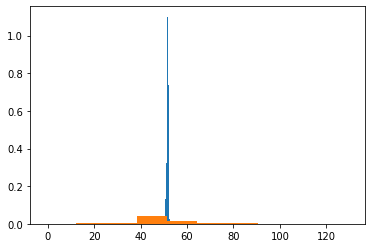

In [ ]:
plt.hist(predictions, density=True)
plt.hist(df['tm'], density=True)

In [ ]:
predictions.max()

52.692093

In [ ]:
predictions.min()

49.74254

In [ ]:
pY

,tm
31390,52.043087
31391,51.593826
31392,51.934589
31393,51.150570
31394,51.559582
...,...
33798,52.238678
33799,52.043015
33800,51.456749
33801,52.170467
